In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize  
from scipy import stats

In [19]:


fn_hub = '/Users/aidasaglinskas/Desktop/BC-Hubs-MentingFang/Hub_vec_corr_avgruns.npy'
fn_roi = '/Users/aidasaglinskas/Desktop/BC-Hubs-MentingFang/ROI_vec_corr_avgruns.npy'

fn_hub = '/Users/aidasaglinskas/Desktop/BC-Hubs-MentingFang/Hub_vec_eculid_avgruns.npy'
fn_roi = '/Users/aidasaglinskas/Desktop/BC-Hubs-MentingFang/ROI_vec_eculid_avgruns.npy'

hub = np.load(fn_hub)
roi = np.load(fn_roi)

hub.shape # (5, 14, 3, 6)
roi.shape # (4, 14, 3, 6)

rlbls = ['roi 1','roi 2','roi 3','roi 4']
rlbls = ['FACE','BODY','OBJECT','SCENE']

hlbls = ['hub 1','hub 2','hub 3','hub 4','hub 5']
hlbls = ['Thalamus', 'Middle Cingulate', 'Posterior Cingulate', 'Angular Gyrus', 'Cerebellum']

203.20502699948523
[ 1.18685629e+01  1.59130822e-01 -1.43360834e-02 -9.09494779e-02
 -4.07881408e-03]
166.96397630284807
[ 1.03972142e+01  1.29235018e-01 -2.07069439e-03 -6.69286149e-02
  7.66553418e-03]
347.5192158614348
[2.97570267 0.05372567 0.26304601 0.15711254 0.01782424]
100.0895261479778
[1.11229632 0.01707819 0.08622032 0.09296178 0.01401878]
161.48514754654866
[ 9.72130700e+00  7.06381076e-02  3.40169345e-02  3.83278358e-02
 -8.48273326e-03]


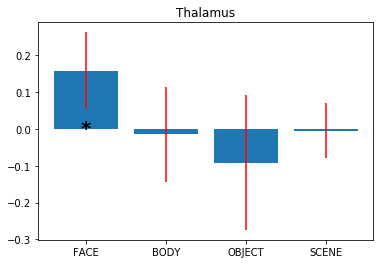

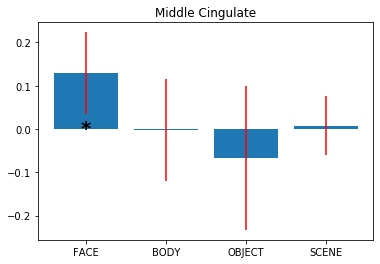

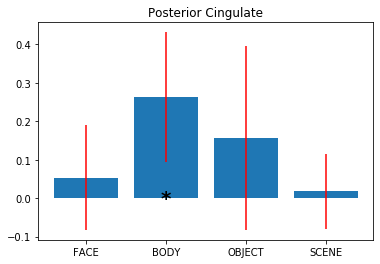

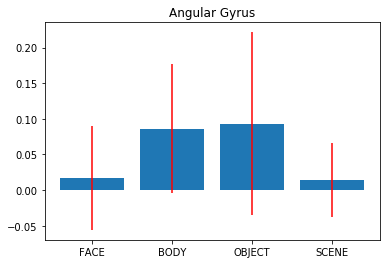

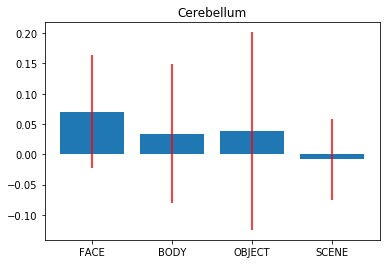

In [20]:
def get_X_matrix(roi_ind,run_ind):
    #    roi_ind = 0
    #    run_ind = 0
    X = np.zeros([14,6])
    for subject in range(roi.shape[1]):
        for dist in range(roi.shape[3]):
            X[subject,dist] = roi[roi_ind,subject,run_ind,dist]
    return X

def get_Y_matrix(hub_ind,run_ind):
    #    hub_ind = 0
    #    run_ind = 0
    Y = np.zeros([14,6])
    for subject in range(hub.shape[1]):
        for dist in range(roi.shape[3]):
            Y[subject,dist] = hub[hub_ind,subject,run_ind,dist]
    return Y

def get_vars(hub_ind,svec):
    # 0th axis is roi/hub index
    # First axis is the subjects
#    Y = hub[hub_ind,svec,:,:].mean(axis=1,keepdims=False)
#    X1 = roi[0,svec,:,:].mean(axis=1,keepdims=False)
#    X2 = roi[1,svec,:,:].mean(axis=1,keepdims=False)
#    X3 = roi[2,svec,:,:].mean(axis=1,keepdims=False)
#    X4 = roi[3,svec,:,:].mean(axis=1,keepdims=False)
    
    Y = hub[hub_ind,svec,:]
    X1 = roi[0,svec,:]
    X2 = roi[1,svec,:]
    X3 = roi[2,svec,:]
    X4 = roi[3,svec,:]
    
    return Y,X1,X2,X3,X4

hub_ind = 0
svec = np.arange(14)

Y,X1,X2,X3,X4 = get_vars(hub_ind,svec)

def optimal_betas(hub_ind,svec):   
    #    hub_ind = 0
    #    svec = np.arange(14)
    Y,X1,X2,X3,X4 = get_vars(hub_ind,svec)
    
    params = np.array([1,2,3,4,5])
    def objective(params):
#        b0 = params[0]
        #b = params[1:] # from 1 to end
        #params[0] = 0
        Y_hat = params[0] + X1*params[1] + X2*params[2] + X3*params[3] + X4*params[4]
        err = Y-Y_hat
        #sum_sq = np.sum(err**2)
        sum_sq = sum(np.linalg.norm(Y-Y_hat,axis=1))
        return sum_sq
    
    #initGuess = [10,10,10,10,10]
    initGuess = [0,0,0,0,0]
    sol = minimize(objective,initGuess,method='SLSQP') 
    
    #print(sol.success)
    #print(sol.fun)
    #print(sol.x)
    #print(sol.message)
    
    return sol.fun,sol.x
#%%
for hub_ind in range(5):
    svec = np.arange(14)
    
    Y,X1,X2,X3,X4 = get_vars(hub_ind,svec)
    err,b = optimal_betas(hub_ind,svec)
    print(err)
    print(b)
    #%
    
    Y_hat = b[0] + X1*b[1] + X2*b[2] + X3*b[3] + X4*b[4]
    
    predictors = [X1,X2,X3,X4]
    coeffs = b[1:]
    SS_res = err
    #SS_res = np.sum(np.linalg.norm(Y-Y_hat,axis=1))
    N = Y.shape[0] #14
    k = len(b) # 5
    
    t_val = []
    df = N-k
    alpha = .05;
    
    critical_t = stats.t.ppf(1-alpha/2,df)
    t_val,upper,lower = [],[],[]
    
    for i in range(len(predictors)):
        std_X = np.linalg.norm(predictors[i],axis=1).std()
        SEb = np.sqrt(SS_res/(N-k-1)) / (std_X * np.sqrt(N-1))
        t = coeffs[i] / SEb
        
        u = +(critical_t*SEb)
        l = -(critical_t*SEb)
        
        t_val.append(t)
        lower.append(l)
        upper.append(u)
        
    xs = np.arange(len(coeffs))
    ys = coeffs

    plt.figure()
    plt.bar(xs,ys)
    plt.errorbar(xs,ys,yerr=upper,ecolor='red',fmt='none')
    plt.title(hlbls[hub_ind])
    plt.xticks(xs,rlbls)
    plt.box(on=True)
    
    for i in xs:
        if t_val[i]>critical_t:
            plt.text(i,0,'*',fontsize=20,fontweight='bold',horizontalalignment='center',verticalalignment='center');
            